✅ Data Loaded. Shape: (2260701, 151)
Target distribution:
 loan_status
0    0.881186
1    0.118814
Name: proportion, dtype: float64
Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.6207
ROC-AUC: 0.6964
              precision    recall  f1-score   support

           0     0.9323    0.6142    0.7405    597621
           1     0.1896    0.6693    0.2954     80580

    accuracy                         0.6207    678201
   macro avg     0.5609    0.6417    0.5180    678201
weighted avg     0.8441    0.6207    0.6876    678201



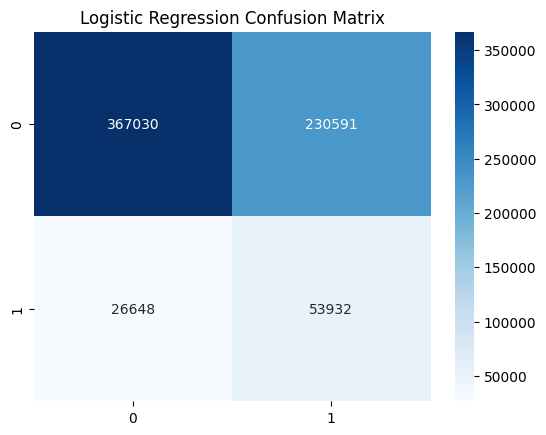

Training Random Forest...


KeyboardInterrupt: 

In [1]:
# =======================================
# 1. Import Libraries
# =======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib

# =======================================
# 2. Load Data
# =======================================
accepted = pd.read_csv(r"D:\Banking DS Project\Loan Default Prediction Model\accepted_2007_to_2018Q4.csv.csv", low_memory=False)
# rejected = pd.read_csv(r"D:\Banking DS Project\Loan Default Prediction Model\rejected_2007_to_2018Q4.csv.csv", low_memory=False)  # Optional

print("✅ Data Loaded. Shape:", accepted.shape)

# =======================================
# 3. Select Features & Target
# =======================================
# Choose a subset of important features (adjust as needed)
features = [
    "loan_amnt", "term", "int_rate", "installment", "grade", "emp_length",
    "home_ownership", "annual_inc", "purpose", "addr_state", "dti",
    "delinq_2yrs", "inq_last_6mths", "open_acc", "revol_bal", "revol_util", "total_acc"
]

target = "loan_status"

df = accepted[features + [target]].dropna(subset=[target])

# Encode target (Default = 1, Not Default = 0)
df[target] = df[target].apply(lambda x: 1 if x.lower() in ["default", "charged off"] else 0)

print("Target distribution:\n", df[target].value_counts(normalize=True))

# =======================================
# 4. Train-Test Split
# =======================================
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# =======================================
# 5. Preprocessing Pipeline
# =======================================
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# =======================================
# 6. Train Models
# =======================================
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced", n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                             subsample=0.8, colsample_bytree=0.8, random_state=42,
                             scale_pos_weight=1, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)
}

results = {}
best_model = None
best_auc = 0

for name, model in models.items():
    print("="*50)
    print(f"Training {name}...")
    
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    results[name] = {"Accuracy": acc, "ROC-AUC": auc}
    
    print(f"\n{name} Results:")
    print("Accuracy:", round(acc, 4))
    print("ROC-AUC:", round(auc, 4))
    print(classification_report(y_test, y_pred, digits=4))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
    # Track best model
    if auc > best_auc:
        best_auc = auc
        best_model = clf

# =======================================
# 7. Save Best Model
# =======================================
joblib.dump(best_model, "loan_default_model.pkl")
print("✅ Best model saved as loan_default_model.pkl")

# =======================================
# 8. Load Model & Predict New Loan
# =======================================
model = joblib.load("loan_default_model.pkl")

new_loan = pd.DataFrame([{
    "loan_amnt": 15000,
    "term": " 36 months",
    "int_rate": 13.5,
    "installment": 500,
    "grade": "C",
    "emp_length": "10+ years",
    "home_ownership": "MORTGAGE",
    "annual_inc": 75000,
    "purpose": "debt_consolidation",
    "addr_state": "CA",
    "dti": 15.2,
    "delinq_2yrs": 0,
    "inq_last_6mths": 1,
    "open_acc": 10,
    "revol_bal": 12000,
    "revol_util": 45.3,
    "total_acc": 25
}])

prob_default = model.predict_proba(new_loan)[:, 1][0]
print(f"\n🔮 Probability of Default: {prob_default:.2f}")
print("Prediction:", "Default" if prob_default > 0.5 else "Not Default")
